# Stochastic modelling and lineages distribution

The section is about modeling stochastic disease dynamics using Gillespie algorithm for heterogeneous SIR model. This approach allows simulating not only Susceptible, Infectious, Recovered numbers but also to keep track the virus lineages dynamics. The hope was to use real lineages' distribution data for comparison and making some conclusions about the virus spread.

## Stochastic model description 
There are infection and recovery(deactivation) events. The recovery events rate is proportional to the number of infected. The number of infection events is proportional to the infection carriers total ability to spread the disease ("spreadability"). The total "spreadability" is just the sum of infectious individuals' "spreadabilities". We are also taking into account the heterogeneity in the ability to catch the disease ("catchability"). The infection event involve the infection spreader and (potential) infection receiver. For each infection event the (potential) receiver is selected with probability proportional to her individual "catchabilty". To take into account the depletion of the number of susceptible over time, we use a very simple trick - if a non-susceptible receiver is involved in an infection event, then the event ends in nothing.

In [1]:
import numpy as np
from sortedcontainers import SortedList
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def select_receiver(catchabilities_cumsum):
    rand=np.random.uniform()*catchabilities_cumsum[-1]
    return np.searchsorted(catchabilities_cumsum,rand)


And the modelling procedure for the dynamics starting from one infected:

In [2]:
def stochastic_dynamics(r0_0,τ,pop_size,spreadability,catchability,T):
    t,S,I=0.0,pop_size-1,1
    catchabilities_cumsum=catchability.cumsum()
    infected=SortedList()
    is_susceptible=np.ones(pop_size,dtype=np.bool_)
    next_spreader=select_receiver(catchabilities_cumsum)
    infected.add(next_spreader)
    is_susceptible[next_spreader]=False
    A=spreadability[next_spreader]
    resT,resS,resI=[t],[S],[I]
    while t<T and I>0:
        events_rate=A*r0_0+I/τ
        t+=np.random.exponential()/events_rate
        if events_rate*np.random.uniform()<A*r0_0:
            #infection_event
            next_spreader=select_receiver(catchabilities_cumsum)
            if is_susceptible[next_spreader]:
                infected.add(next_spreader)
                A+=spreadability[next_spreader]
                is_susceptible[next_spreader]=False
                S-=1
                I+=1
        else: 
            #deactivation_event
            rand=np.random.uniform()*I
            A -= spreadability[infected.pop(int(rand))]
            I-=1
        resT.append(t)
        resI.append(I)
        resS.append(S)
    return np.array(resT),np.array(resS),np.array(resI)
    

If we set spreadabilities and catchabilities and $\tau$ all equal to one, we must get ordinary SIR dynamics. And we can compare it with HCS_SIR with zero variances.

In [3]:
modeling_period=9.0
t_step=0.003
m_t=np.arange(0.0, modeling_period+t_step, t_step,dtype=np.float64)

def HCS_SIR(r0_0,I0,τ,vs0,vb0):
    '''
    Heterogeneous in Catching and Spreading
    SIR model
    '''
    def M(mu,v):return np.exp(mu+0.5*v)
    def a_s(mus,C,vs):
        Cpvs=C+vs
        return M(mus,vs)*(1.0+Cpvs*(1.0+0.5*Cpvs))
    M0=M(0.0,vs0+vb0)
    a_s0=r0_0*a_s(0.0,0.0,vs0)/(r0_0-1.0+1.0/τ)
    α=r0_0/M0/a_s0
    
    def ODE(y,t):
        S,I,A,mus,mub,C,vs,vb=y
        Cpvs=C+vs
        Cpvb=C+vb 
        minus_αMA=-α*M(mus+mub,Cpvs+Cpvb)*A

        dS = minus_αMA*S
        dI = -dS - I
        dA= -a_s(mus,C,vs)*dS-A/τ
        dmus = minus_αMA*Cpvs
        dmub = minus_αMA*Cpvb
        dC = dmus*Cpvb
        dvs = dmus*Cpvs
        dvb = dmub*Cpvb
        return [dS, dI,dA, dmus,dmub,dC,dvs,dvb]
    
    A0=a_s0*I0
    y0=[1.0-I0,I0,A0,0.0,0.0,0.0,vs0,vb0]
    
    sol = odeint(ODE,y0, m_t).T
    S,I,A,mus,mub,C,vs,vb=sol
    return S,I


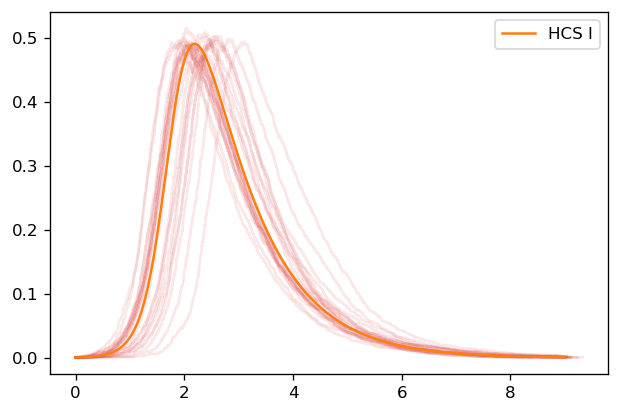

In [4]:
r0_0,τ,population_size,T=5.2,1.0,2000,modeling_period
spreadability=np.ones(population_size)
catchability=np.ones(population_size)
fig, ax = plt.subplots(dpi=120)
for n in range(30):
    t,_,i=stochastic_dynamics(r0_0,τ,population_size,spreadability,catchability,T)
    plt.plot(t, i/population_size,color='C3', alpha=0.1)
s,i=HCS_SIR(r0_0,1.0/population_size,τ,0,0)
plt.plot(m_t, i,color='C1', label=f'HCS I')
plt.legend(loc='upper right')
plt.show()

Let's try less trivial spreadabilities and catchabilities distribution. We can represent catchability as a product of "social" and "biological" parts. "Social" part is like person social activity and reflects how often he encounter other people in, say, indoor conditions. You can imagine "biological" part as ability to catch the disease in some standard condition of infection spread (standard room, standard spreader, standard distance and so on). Similarly, for spreadability. Important note is that "social" part of spreadability is in fact the same as "social" part of catchability and controlled by the same variance $v_s(0)$.

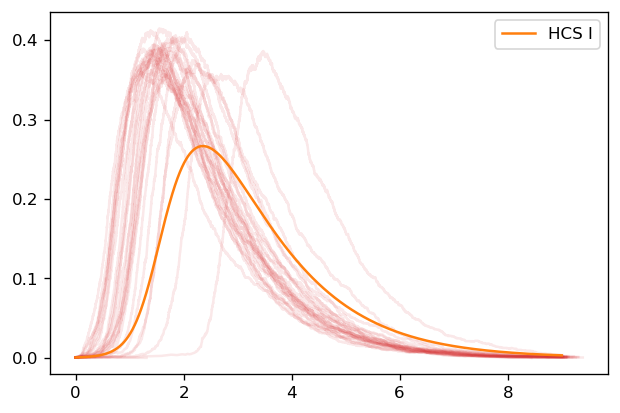

In [5]:
vs0=0.5 #social activity
vbc=0.4 #biological part of catchability
vbs=0.3 #biological part of spreadability
def get_lognormal_with_unit_mean(size,v):#lognormal disr with unit mean and log variance v
    return np.exp(np.random.normal(size=size)*np.sqrt(v)-v/2)
    
social_activity=get_lognormal_with_unit_mean(population_size,vs0) 
catchability_biological_part=get_lognormal_with_unit_mean(population_size,vbc) 
spreadability_biological_part=get_lognormal_with_unit_mean(population_size,vbs)

catchability=social_activity*catchability_biological_part
spreadability=social_activity*spreadability_biological_part

τ=1.0

fig, ax = plt.subplots(dpi=120)
for n in range(30):
    t,_,i=stochastic_dynamics(r0_0,τ,population_size,spreadability,catchability,T)
    plt.plot(t, i/population_size,color='C3', alpha=0.1)
s,i=HCS_SIR(r0_0,1.0/population_size,τ,vs0,vbc)
plt.plot(m_t, i,color='C1', label=f'HCS I')
plt.legend(loc='upper right')
plt.show()


This time the dynamics of deterministic and stochastic models is rather different. The problem is the stochastic model has no calibrated initial dynamics as you can see in log scale:

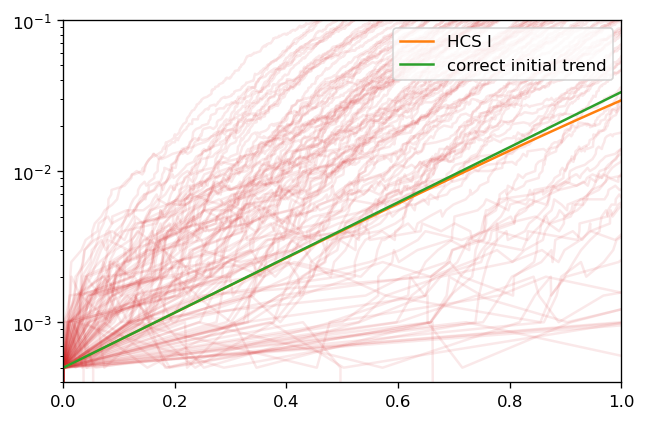

In [6]:
fig, ax = plt.subplots(dpi=120)
for n in range(150):
    t,_,i=stochastic_dynamics(r0_0,τ,population_size,spreadability,catchability,T)
    plt.plot(t, i/population_size,color='C3', alpha=0.1)
s,i=HCS_SIR(r0_0,1.0/population_size,τ,vs0,vbc)
plt.plot(m_t, i,color='C1', label=f'HCS I')
plt.plot(m_t, np.exp(m_t*(r0_0-1.0))/population_size,color='C2', label=f'correct initial trend')
plt.yscale('log')
ax.set_xlim([0.0,1.0])
ax.set_ylim([0.0004,0.1])
plt.legend(loc='upper right')
plt.show()

To fix this we will use $r_0(0)$ value corrected according to formulas for HCS_SIR (just guess).

$$
r_0^*(0) = \frac{r_0(0) + 1/\tau - 1.0} {a_s(0)}=\frac{r_0(0) + 1/\tau - 1.0} {M_s(0)(1+v_s(0)+v_s^2(0)/2)}
$$

$M_s(0)$ in our case is 1 because we initialize distributions the way they have unit mean. 

Let's look now:

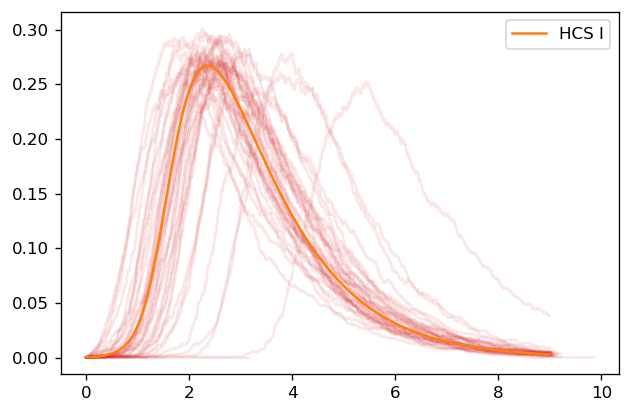

In [7]:
def r0_corrected(r0_0,vs0,τ):
    return (r0_0 + 1.0/τ - 1.0)/(1.0+vs0+vs0*vs0/2)
τ=1.0
fig, ax = plt.subplots(dpi=120)
for n in range(50):
    t,_,i=stochastic_dynamics(r0_corrected(r0_0,vs0,τ),τ,population_size,spreadability,catchability,T)
    plt.plot(t, i/population_size,color='C3', alpha=0.1)
s,i=HCS_SIR(r0_0,1.0/population_size,τ,vs0,vbc)
plt.plot(m_t, i,color='C1', label=f'HCS I')
plt.legend(loc='upper right')
plt.show()

So, our guess about using our findings for HCS_SIR to correct $r_0(0)$ value was right. Now the dynamics looks pretty much the same.

It is time to make a correction in the model to deal with non unit $\tau$ values. The $\tau$ value describe an active (infectious) part of all infected. For exapmle $\tau=0.4$ implies that around 40% of infected is actively spread the disease according to their spreadabilities, while around 60% of infected do not spread. For $\tau=1$ deactivation and recovery events is the same, but it it is not true for general case. Generally deactivation event reduces the number of active spreaders and total spreadability, while recovery event reduces the number of infected. 
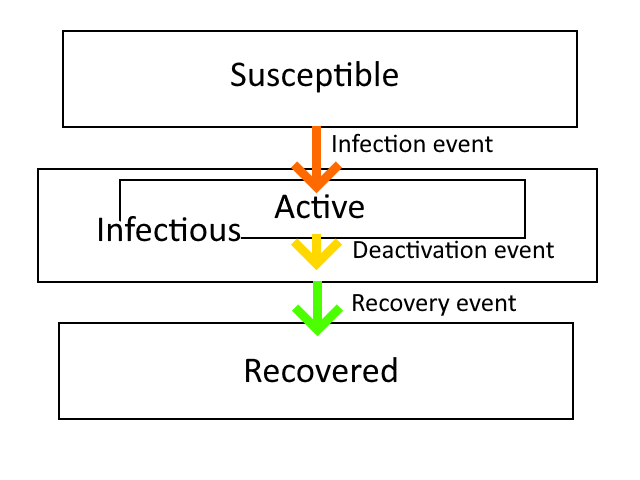
In our implementation we generate recovery events inside deactivation event. The time interval from last deactivation event is filled with recovery events with rate proportional to number of infectious.  This apprach has small drawback at the end of the trajectory when the rate of deactivation events is slow. Some small amount of passive infected can stuck unrecovered because too few infectious generating deactivation events. But this effect is small and happens at the least interesting part of the trajectory.   

In [8]:
def stochastic_dynamics2(r0_0,τ,vs0,pop_size,spreadability,catchability,T):
    t,S,I_active,I_total=0.0,pop_size-1,1,1
    r0_0=(r0_0 + 1.0/τ - 1.0)/(1.0+vs0+vs0*vs0/2)
    catchabilities_cumsum=catchability.cumsum()
    infected=SortedList()
    is_susceptible=np.ones(pop_size,dtype=np.bool_)
    next_spreader=select_receiver(catchabilities_cumsum)
    infected.add(next_spreader)
    is_susceptible[next_spreader]=False
    A=spreadability[next_spreader]
    resT,resS,resI=[t],[S],[I_total]
    t_deactivation=t;
    while t<T and I_active>0:
        events_rate=A*r0_0+I_active/τ
        t+=np.random.exponential()/events_rate
        if events_rate*np.random.uniform()<A*r0_0:
            #infection_event
            next_spreader=select_receiver(catchabilities_cumsum)
            if is_susceptible[next_spreader]:
                infected.add(next_spreader)
                A+=spreadability[next_spreader]
                is_susceptible[next_spreader]=False
                S-=1
                I_active+=1
                I_total+=1
        else: 
            #deactivation_event
            rand=np.random.uniform()*I_active
            A -= spreadability[infected.pop(int(rand))]
            I_active-=1
            while I_active<I_total:
                #recovery events
                t_deactivation+=np.random.exponential()/I_total
                if t_deactivation>t:break
                I_total-=1
            t_deactivation=t
        resT.append(t)
        resI.append(I_total)
        resS.append(S)
    return np.array(resT),np.array(resS),np.array(resI)
    

New version with non unit $\tau$

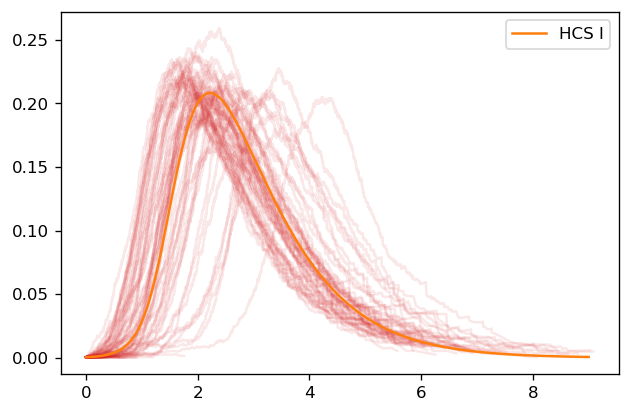

In [9]:
τ=0.4
fig, ax = plt.subplots(dpi=120)
for n in range(120):
    t,_,i=stochastic_dynamics2(r0_0,τ,vs0,population_size,spreadability,catchability,T)
    plt.plot(t, i/population_size,color='C3', alpha=0.1)
s,i=HCS_SIR(r0_0,1.0/population_size,τ,vs0,vbc)
plt.plot(m_t, i,color='C1', label=f'HCS I')
plt.legend(loc='upper right')
plt.show()

For COVID-19 there are evidence of repeated infection. We can modify the outbreak SIR model to reflect repeated infection and to get SIRS model. In the SIRS model Recovered become Susceptible in time. 

To get SIRS model we divide Infected onto Active and Passive compartments (previously Active infected was a subset of Infected):
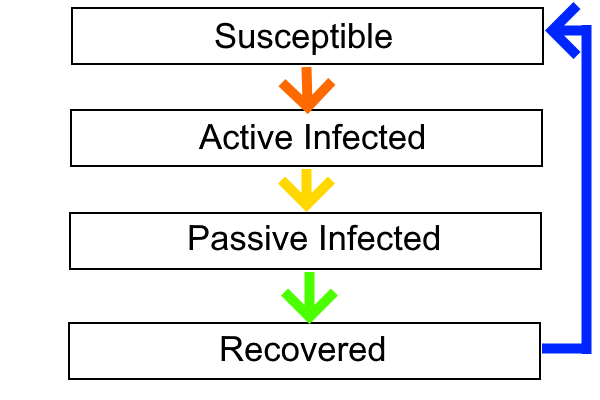

In [10]:
def stochastic_SIRS(r0_0,τ,vs0,become_susceptible_coef,pop_size,spreadability,catchability,T):
    
    #initialization
    t,S,I_active,I_passive,R=0.0,pop_size-1,1,0,0
    r0_0=(r0_0 + 1.0/τ - 1.0)/(1.0+vs0+vs0*vs0/2)
    catchabilities_cumsum=catchability.cumsum()
    active_infected=SortedList()
    passive_infected=SortedList()
    recovered=SortedList()
    is_susceptible=np.ones(pop_size,dtype=np.bool_)
    resT,resS,resI=[t],[S],[I_active]
    
    #first spreaer
    next_spreader=select_receiver(catchabilities_cumsum)
    active_infected.add(next_spreader)
    is_susceptible[next_spreader]=False
    A=spreadability[next_spreader]
    
    #events cicle
    while t<T and I_active>0:
        inf_rate=A*r0_0
        inf_and_deact_rate=inf_rate+I_active/τ
        inf_and_deact_and_recov_rate=inf_and_deact_rate+ I_passive/(1.0-τ)
        events_rate=inf_and_deact_and_recov_rate+become_susceptible_coef*R       
        t+=np.random.exponential()/events_rate
        rnd=events_rate*np.random.uniform()
        if rnd<inf_rate:
            #infection_event
            next_spreader=select_receiver(catchabilities_cumsum)
            if is_susceptible[next_spreader]:
                active_infected.add(next_spreader)
                A+=spreadability[next_spreader]
                is_susceptible[next_spreader]=False
                S-=1
                I_active+=1
        elif rnd<inf_and_deact_rate: 
            #deactivation_event
            person=active_infected.pop(int(np.random.uniform()*I_active))
            passive_infected.add(person)
            A -= spreadability[person]
            I_active-=1
            I_passive+=1
        elif rnd<inf_and_deact_and_recov_rate:
            #recovery event
            person=passive_infected.pop(int(np.random.uniform()*I_passive))
            recovered.add(person)
            R+=1
            I_passive-=1
        else:
            #become susceptible again event
            person=recovered.pop(int(np.random.uniform()*R))
            is_susceptible[person]=True
            R-=1
            S+=1
        resT.append(t)
        resI.append(I_active+I_passive)
        resS.append(S)
        
    return np.array(resT),np.array(resS),np.array(resI)


If we set become_susceptible_coef to zero we must get previous dynamics:

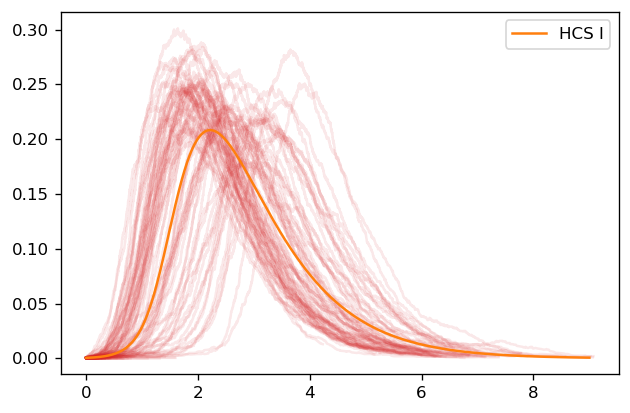

In [11]:
τ=0.4
fig, ax = plt.subplots(dpi=120)
for n in range(170):
    t,_,i=stochastic_SIRS(r0_0,τ,vs0,0.0,population_size,spreadability,catchability,T)
    plt.plot(t, i/population_size,color='C3', alpha=0.1)
s,i=HCS_SIR(r0_0,1.0/population_size,τ,vs0,vbc)
plt.plot(m_t, i,color='C1', label=f'HCS I')
plt.legend(loc='upper right')
plt.show()

But not exactly the same. As you can see, the trajectories are higher now. This is the result of splitting Infectious compartment. Average recovery time stays unchanged but its variance shrinks.

To fix the difference between the stochastic model and HCS_SIR, we modify the latter by dividing the Infection compartment too.

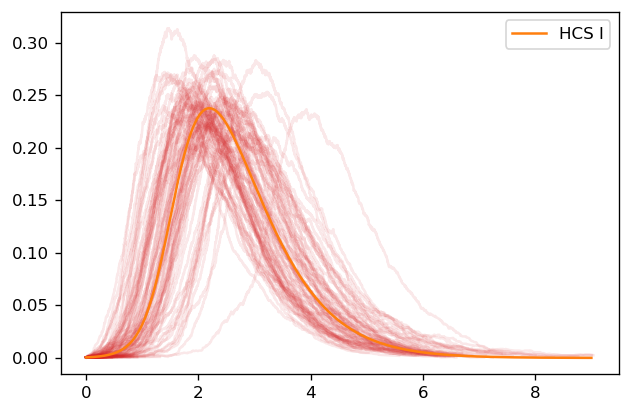

In [12]:
def HCS_SIR2(r0_0,I0,τ,vs0,vb0):
    '''
    Heterogeneous in Catching and Spreading
    SIR model
    '''
    def M(mu,v):return np.exp(mu+0.5*v)
    def a_s(mus,C,vs):
        Cpvs=C+vs
        return M(mus,vs)*(1.0+Cpvs*(1.0+0.5*Cpvs))
    M0=M(0.0,vs0+vb0)
    a_s0=r0_0*a_s(0.0,0.0,vs0)/(r0_0-1.0+1.0/τ)
    α=r0_0/M0/a_s0
    
    def ODE(y,t):
        S,I_a,I_p,A,mus,mub,C,vs,vb=y
        Cpvs=C+vs
        Cpvb=C+vb 
        γ_a=1/τ
        γ_p=1/(1-τ)
        minus_αMA=-α*M(mus+mub,Cpvs+Cpvb)*A

        dS = minus_αMA*S
        dI_a = -dS - γ_a*I_a
        dI_p = γ_a*I_a -  γ_p*I_p
        dA= -a_s(mus,C,vs)*dS-γ_a*A
        dmus = minus_αMA*Cpvs
        dmub = minus_αMA*Cpvb
        dC = dmus*Cpvb
        dvs = dmus*Cpvs
        dvb = dmub*Cpvb
        return [dS, dI_a,dI_p,dA, dmus,dmub,dC,dvs,dvb]
    
    A0=a_s0*I0
    y0=[1.0-I0,I0,0.0,A0,0.0,0.0,0.0,vs0,vb0]
    
    sol = odeint(ODE,y0, m_t).T
    S,I_a,I_p,A,mus,mub,C,vs,vb=sol
    #dS=-ODE(sol,m_t)[0]
    return S,I_a+I_p

fig, ax = plt.subplots(dpi=120)
for n in range(170):
    t,_,i=stochastic_SIRS(r0_0,τ,vs0,0.0,population_size,spreadability,catchability,T)
    plt.plot(t, i/population_size,color='C3', alpha=0.1)
s,i=HCS_SIR2(r0_0,1.0/population_size,τ,vs0,vbc)
plt.plot(m_t, i,color='C1', label=f'HCS I')
plt.legend(loc='upper right')
plt.show()

The difference is fixed, but the question still remained: what model is more realistic with one Infectious compartment or divided Infectious compartment. To answer this question, more information is needed on the real distribution of recovery time.

To model lineages distribution the model with divided Infectious compartment is more suitable. So, we use it.

Meanwhile, let's look at long term dynamic then Recovered become Susceptible. We use become_susceptible_coef equal to 0.1. That means a recovered become susceptible in average in 10 time units (one time unit - average recovery time - around 16 days). For smaller become_susceptible_coef almost all trajectories are dying out in like 10 time units, and we need much bigger population size to prevent it.

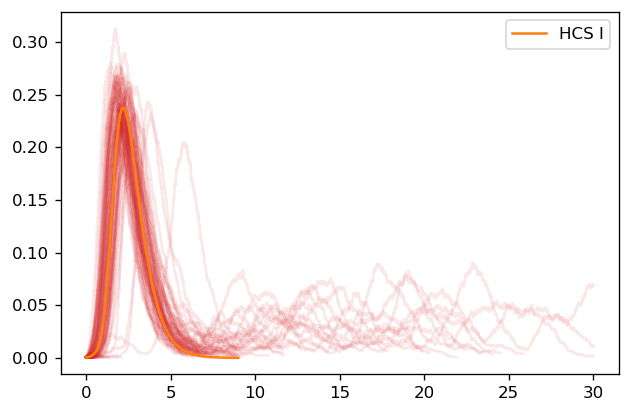

In [13]:
become_susceptible_coef=0.1 
T=30.
fig, ax = plt.subplots(dpi=120)
for n in range(170):
    t,s,i=stochastic_SIRS(r0_0,τ,vs0,become_susceptible_coef,population_size,spreadability,catchability,T)
    plt.plot(t, i/population_size,color='C3', alpha=0.1)
s,i=HCS_SIR2(r0_0,1.0/population_size,τ,vs0,vbc)
plt.plot(m_t, i,color='C1', label=f'HCS I')
plt.legend(loc='upper right')
plt.show()

Current python implementation is to slow to model population size more than few thousand. Besides, it will slow down even more, if we implement lineages tracing on the top of it. So, we make much faster C++ implementation.